<H1 align="center"> <div class="alert alert-block alert-info"><b></b>Etapa de modelamiento</div></H1>

**Nota: Dejé al inicio las librerías para que sea más fácil el incorporar al notebook principal aquellas que faltan, y también las funciones que se deben traspasar al archivo auxiliar.**

**Librerías**

In [19]:
# Uso general y exploracion de data
import pandas as pd
import numpy as np
import csv
import missingno as msno
import io
import matplotlib.pyplot as plt

# Procesamiento de Texto
from spellchecker import SpellChecker
spell = SpellChecker(language='es')
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('es_core_news_sm', disable=["tagger", "parser"])
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('spanish')
from string import punctuation
import re

# funciones auxiliares
import h2_funciones_auxiliares as fx

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Para implementar modelos de machine learning.
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve
from sklearn import set_config
set_config(display = 'diagram')

# Para recodificación de atributos
from category_encoders import TargetEncoder, OrdinalEncoder, OneHotEncoder

from datetime import datetime

# Para visualización
import graphviz

# Para serialización
import pickle

# Para evitar mensajes de deprecación
import warnings 
warnings.filterwarnings("ignore")

#### Función para obtener classification report en train y test set.

In [2]:
# FUNCIÓN PARA OBTENER CLASSIFICATION REPORT:
def report(y_train, y_pred_train, y_test, y_pred):
    print("Classification report - TRAIN SET")
    print(classification_report(y_train, y_pred_train))
    print("\nClassification report - TEST SET")
    print(classification_report(y_test, y_pred))

# FUNCIÓN PARA CLASSIFICATION REPORT - SÓLO TEST SET
def test_classification_report(nombre_modelo, y_test, y_hat):
    print("\nTEST SET - Classification report - {}".format(nombre_modelo.upper()) )
    print(classification_report(y_test, y_hat))

#### Función para depurar dataframe, previo al modelamiento.

In [3]:
def dataset_year_filter(dataframe,year):
    """
    dataset_year_filter - Permite depurar el data set - con 9 columnas - en función del año requerido. 

    @parámetros:
        - dataframe: Parámetro obligatorio. Set de datos por analizar, correspondiente al tipo pandas.core.frame.DataFrame.
        - year: Parámetro obligatorio. Año por el cual se busca realizar el filtro de observaciones en el dataset. 

    @salida:
        - Dataframe depurado.
    """
    
    if len(dataframe.columns) == 9:
        
        # Eliminación de columnas que no serán requeridas para generar el dataset depurado
        dataframe_tmp = dataframe.drop(columns = ['retail','codigo','producto'])
        
        if year == 2020:
            # Filtro por año
            dataframe_tmp = dataframe_tmp[dataframe_tmp['año'] == 2020]
            
        if year == 2021:
            dataframe_tmp = dataframe_tmp[dataframe_tmp['año'] == 2021]
        
        # Eliminación de columna año y mes
        dataframe_tmp = dataframe_tmp.drop(columns = ['año','mes'])
        
        # Reseteo del índice del dataframe
        dataframe_tmp = dataframe_tmp.reset_index().drop(columns="index")
        
        return dataframe_tmp

In [4]:
def entrenamiento_modelo_base(modelo, X_train, y_train, nombre_modelo):
    """
    entrenamiento_modelo_base - Permite entrenar un modelo base sin modificación de hiperparámetros, obteniendo su serialización.

    @parámetros:
        - modelo: Parámetro obligatorio. Modelo a implementar, previamente instanciado. 
        - X_train: Parámetro obligatorio. Matriz de atributos de entrenamiento.
        - y_train:Parámetro obligatorio. Vector objetivo de entrenamiento.
        - nombre_modelo: Parámetro obligatorio. Nombre que se asignará al modelo, para identificación. 
    @salida:
        - Modelo serializado.
    """
    pipe = Pipeline(steps = [
    ("tran", tran),
    ("modelo", modelo)])
    
    modelo_tmp = pipe.fit(X_train, y_train)
    
    return modelo_tmp, pickle.dump(modelo_tmp, open(nombre_modelo,"wb"))

In [24]:
def prediccion_reporte_modelo(nombre_modelo, X_train, X_test, y_test):
    """
    prediccion_modelo - Permite realizar las predicciones en base a un modelo previamente serializado, 
    y obtener métricas de desempeño asociadas, tanto para el Train Set como para Test Set. 

    @parámetros:
    - nombre_modelo: Parámetro obligatorio. Nombre de identificación del modelo serializado.
    - X_train: Parámetro obligatorio. Matriz de atributos de entrenamiento.
    - X_test: Parámetro obligatorio. Matriz de atributos para predicciones.
    - y_test:Parámetro obligatorio. Vector objetivo de testeo.
        
    @salida:
        - Reporte de las métricas obtenidas.
    """
    
    # Carga del modelo con pickle
    modelo_tmp = pickle.load(open(nombre_modelo,"rb"))

    # Predicciones para modelo 
    y_pred_train = modelo_tmp.predict(X_train)
    y_pred = modelo_tmp.predict(X_test)
    
    return report(y_train, y_pred_train, y_test, y_pred)

## 9.1. Criterios considerados para el modelamiento
El proceso de modelamiento realizado a la fecha considera los siguientes criterios:
- Data set y división de muestras:  Para realizar el proceso de **entrenamiento y testing** se utilizará la data correspondiente al **año 2020**, implementando en ella la división de la muestra por medio de train_test_split, preservando un **60% para train y un 40% para test**. Por otra parte, la data perteneciente al **año 2021** se empleará en su totalidad para el proceso de **validación**.


- En vista de los datos requeridos para 'sentitruster', se define que la **matriz de atributos** contenga las siguientes variables: **'categoria', 'precio_internet' y 'comentario'**, mientras que el **vector objetivo**, como se mencionó anteriormente, es **'rating'**.


- Se implementará un **Pipeline**, en el cual se aplicará **OneHotEncoder** a la variable **'categoria'**, generándose una columna por cada categoría presente en el data set; asimismo la variable **'comentario'** pasará por el proceso asociado a la aplicación de **CountVectorizer**.


- Con miras a realizar un análisis apropiado y obtener los mejores resultados, el proceso de modelamiento se dividirá en las siguientes sub-etapas:

    1. Modelamiento sobre **data general**: 
    
        - En primera instancia se implementarán **7 modelos sin modificación alguna de sus hiperparámetros** sobre la **data en general**, es decir, **sin segmentar por categoría**. Éstos constituirán los **modelos base**, a fin de definir aquellos con mejor desempeño y para establecer una posterior **comparación** con aquellos modelos en los que sí se aplicará una **modificación** de hiperparámetros. Para la evaluación se considerará si hubo sobreajuste sobre el train set, y para el test set se analizará la capacidad predictiva de las clases y el desempeño general en base a la métrica F1 macro avg y F1 weighted avg.
        
        - En segundo lugar, se procederá con la implementación de los **2 modelos con mejores resultados** del paso anterior,  **modificando sus hiperparámetros** en función de una **grilla** específica para cada uno, mediante **GridSearch**. Y también se generará y revisará la **matriz de confusión**. 
        
        - De acuerdo a los resultados obtenidos del paso anterior se aplicará, en ellos (uno o ambos) el método **SMOTE oversampling** para abordar el **desbalanceo de clases**, del cual se escogerá el **mejor modelo**. 
        
    2. Modelamiento sobre **data segmentada**: 
    
        - Se aplicarán los pasos descritos con anterioridad, pero a partir de los **2 modelos** identificados con mejor desempeño del punto anterior. La **segmentación** se realizará en base a **categorías de producto**, agrupando aquellas que respondan a **características de población y distribución similar**, analizando si de aquella forma es posible mejorar la **capacidad predictiva** de los modelos.

<H4 align="center"> <div class="alert alert-block alert-info"><b></b>Revisar si los pasos de este apartado se realizaron en etapas anteriores. De no ser así, hay que dejar aquellos que sean requeridos. Descartar los repetidos</div></H4>

## 9.x. Carga y depuración del set de datos

### x. Carga del set de datos

In [6]:
df = pd.read_csv('retail_full.csv')

### x. Filtro del set de datos para entrenamiento en función del año.

In [7]:
df_retail = dataset_year_filter(df,2020)

### x. Implementación countvectorizer

In [8]:
%%time
cv_prep =CountVectorizer(analyzer = 'word',
                    preprocessor = fx.preprocess_text,
                    stop_words = fx.new_stop_words, 
                    min_df =1,
                    ngram_range =(1,1),
                    lowercase = True)


cv_fit = cv_prep.fit_transform(df_retail['comentario'])

CPU times: user 17min 9s, sys: 2.03 s, total: 17min 11s
Wall time: 17min 20s


<H4 align="center"> <div class="alert alert-block alert-info"><b></b>Fin del bloque a revisar</div></H4>

## 9.2. Definición de Pipeline para modelamiento

Se asignan las variables del dataset para apropiada implementación del pipeline:

In [14]:
# Variable categórica - Aplicación OneHotEncoder.
is_cat = 'categoria'

# Variable que será abordada con CountVectorizer.
var_vec = 'comentario'

Definición de los pasos y transformación:

In [15]:
categoricas = Pipeline(steps = [
    ("ohe", OneHotEncoder(use_cat_names = True))])

vectorizada = Pipeline(steps = [
    ("cv_prep", cv_prep)])

tran = ColumnTransformer(transformers = [
    ("cat", categoricas, is_cat),
    ("vec",vectorizada, var_vec)])

### 9.3. Definición de matriz de atributos y vector objetivo

In [16]:
# Matriz de atributos
X = df_retail.drop(columns = 'rating')

# Vector objetivo
y = df_retail['rating']

### 9.4. División de la muestra
De la muestra total (data 2020) se destinará un 60% a entrenamiento y un 40% a testeo.

In [17]:
# División de la muestra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 123)

### 9.5. Modelamiento General - Modelos base (sin modificación de hiperparámetros)

### 9.5.1. Declaración de modelos a implementar

In [20]:
modelo_svc = LinearSVC(random_state = 123)
modelo_mnb = MultinomialNB()
modelo_rf = RandomForestClassifier(random_state = 123)
modelo_dtc = DecisionTreeClassifier(random_state= 123)
modelo_abc = AdaBoostClassifier(random_state = 123)
modelo_gbc = GradientBoostingClassifier(random_state = 123)
modelo_xgb = XGBClassifier(random_state = 123)

### 9.5.2. Implementación de modelos base

### a. LinearSVC

```python
pipe_1 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_1", modelo_svc)
])

modelo1 = pipe_1.fit(X_train, y_train)

#serialización
pickle.dump(modelo1, open("modelo1_svc.sav","wb"))
````

In [23]:
prediccion_reporte_modelo("modelo1_svc.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.97      0.88      0.93       627
         2.0       1.00      0.91      0.96       186
         3.0       1.00      0.83      0.91       263
         4.0       1.00      0.73      0.84       553
         5.0       0.93      1.00      0.96      3994

    accuracy                           0.95      5623
   macro avg       0.98      0.87      0.92      5623
weighted avg       0.95      0.95      0.95      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.58      0.53      0.55       427
         2.0       0.15      0.07      0.09       105
         3.0       0.20      0.09      0.12       185
         4.0       0.23      0.14      0.17       365
         5.0       0.81      0.91      0.86      2667

    accuracy                           0.73      3749
   macro avg       0.39      0.35      0.36      3749
weighted 

(None, array([5., 5., 5., ..., 5., 5., 1.]))

Para el modelo LinearSVC observamos que en el train set existe un marcado sobreajuste. En el test set, el modelo tiene la capacidad para predecir de buena forma las clases extremas (1 y 5), en desmedro del resto.

### b. MultinomialNB

```python
pipe_2 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_2", modelo_mnb)
])

modelo2 = pipe_2.fit(X_train, y_train)

#serialización
pickle.dump(modelo2, open("modelo2_mnb.sav","wb"))
```

In [25]:
prediccion_reporte_modelo("modelo2_mnb.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.83      0.66      0.73       627
         2.0       0.97      0.33      0.49       186
         3.0       0.99      0.27      0.42       263
         4.0       0.84      0.31      0.46       553
         5.0       0.83      0.99      0.90      3994

    accuracy                           0.83      5623
   macro avg       0.89      0.51      0.60      5623
weighted avg       0.84      0.83      0.80      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.67      0.54      0.60       427
         2.0       0.67      0.02      0.04       105
         3.0       0.14      0.01      0.01       185
         4.0       0.25      0.04      0.07       365
         5.0       0.78      0.98      0.87      2667

    accuracy                           0.76      3749
   macro avg       0.50      0.32      0.32      3749
weighted 

En la implementación de MultinomialNB, y considerando los resultados del modelo anterior, vemos que no existiría un sobreajuste considerable en el train set. La métrica F1 es aceptable, pero un tanto inferior en términos ponderados (weighted avg).

### c. RandomForest

```python
pipe_3 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_3", modelo_rf)
])
modelo3 = pipe_3.fit(X_train, y_train)

#serialización
pickle.dump(modelo3, open("modelo3_rf.sav","wb"))
````

In [26]:
prediccion_reporte_modelo("modelo3_rf.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       1.00      0.96      0.98       627
         2.0       0.99      0.97      0.98       186
         3.0       1.00      0.94      0.97       263
         4.0       0.99      0.91      0.95       553
         5.0       0.98      1.00      0.99      3994

    accuracy                           0.98      5623
   macro avg       0.99      0.96      0.97      5623
weighted avg       0.98      0.98      0.98      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.72      0.51      0.59       427
         2.0       0.67      0.02      0.04       105
         3.0       0.36      0.03      0.05       185
         4.0       0.20      0.03      0.06       365
         5.0       0.77      0.97      0.86      2667

    accuracy                           0.76      3749
   macro avg       0.54      0.31      0.32      3749
weighted 

Para el modelo con RandomFores observamos la existencia de un gran sobreajuste en el train set, por tanto se descartará seguir con este en los próximos pasos.

### d. DecisionTree Classifier

```python
pipe_4 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_4", modelo_dtc)
])
modelo4 = pipe_4.fit(X_train, y_train)

#serialización
pickle.dump(modelo4, open("modelo4_dtc.sav","wb"))
````

In [27]:
prediccion_reporte_modelo("modelo4_dtc.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.99      0.96      0.98       627
         2.0       0.99      0.98      0.98       186
         3.0       1.00      0.94      0.97       263
         4.0       0.97      0.93      0.95       553
         5.0       0.98      0.99      0.99      3994

    accuracy                           0.98      5623
   macro avg       0.99      0.96      0.97      5623
weighted avg       0.98      0.98      0.98      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.46      0.48      0.47       427
         2.0       0.13      0.10      0.11       105
         3.0       0.10      0.07      0.08       185
         4.0       0.13      0.12      0.13       365
         5.0       0.80      0.83      0.81      2667

    accuracy                           0.66      3749
   macro avg       0.32      0.32      0.32      3749
weighted 

Al igual que con el modelo con RandomForest, observamos sobreajuste en el train set y una menor métrica F1 weighted average, por tanto, se descartará.

### e. AdaBoostClassifier

```python
pipe_5 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_5", modelo_abc)
])
modelo5 = pipe_5.fit(X_train, y_train)

#serialización
pickle.dump(modelo5, open("modelo5_abc.sav","wb"))
````

In [28]:
prediccion_reporte_modelo("modelo5_abc.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.67      0.39      0.50       627
         2.0       0.34      0.15      0.21       186
         3.0       0.60      0.01      0.02       263
         4.0       0.26      0.01      0.02       553
         5.0       0.76      0.98      0.86      3994

    accuracy                           0.75      5623
   macro avg       0.53      0.31      0.32      5623
weighted avg       0.68      0.75      0.67      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.71      0.42      0.53       427
         2.0       0.11      0.06      0.07       105
         3.0       0.11      0.01      0.01       185
         4.0       0.27      0.01      0.02       365
         5.0       0.76      0.98      0.86      2667

    accuracy                           0.75      3749
   macro avg       0.39      0.29      0.30      3749
weighted 

A diferencia de los modelos implementados con anterioridad, no se evidencia sobreajuste en el train set y la métrica F1 weighted average es aceptable, no habiendo un mayor gap entre el test set y train set. 

### f. GradientBoosting Classifier

```python
pipe_6 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_6", modelo_gbc)
])
modelo6 = pipe_6.fit(X_train, y_train)

#serialización
pickle.dump(modelo6, open("modelo6_gbc.sav","wb"))
````

In [29]:
prediccion_reporte_modelo("modelo6_gbc.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.84      0.47      0.60       627
         2.0       1.00      0.32      0.48       186
         3.0       1.00      0.12      0.21       263
         4.0       0.95      0.11      0.19       553
         5.0       0.78      1.00      0.87      3994

    accuracy                           0.79      5623
   macro avg       0.91      0.40      0.47      5623
weighted avg       0.82      0.79      0.73      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.74      0.42      0.54       427
         2.0       0.18      0.03      0.05       105
         3.0       0.13      0.01      0.02       185
         4.0       0.35      0.02      0.05       365
         5.0       0.76      0.99      0.86      2667

    accuracy                           0.75      3749
   macro avg       0.43      0.29      0.30      3749
weighted 

Se obtienen resultados similares al modelo implementado con AdaBoost. No hay evidencia de sobreajuste y la métrica F1 weighted average es aceptable.

### g. XG Boosting

```python
pipe_7 = Pipeline(steps = [
    ("tran", tran),
    ("modelo_7", modelo_xgb)
])
modelo7 = pipe_7.fit(X_train, y_train)

#serialización
pickle.dump(modelo7, open("modelo7_xgb.sav","wb"))
````

In [30]:
prediccion_reporte_modelo("modelo7_xgb.sav", X_train, X_test, y_test)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.90      0.64      0.75       627
         2.0       0.99      0.49      0.66       186
         3.0       0.97      0.37      0.53       263
         4.0       0.99      0.31      0.47       553
         5.0       0.83      1.00      0.90      3994

    accuracy                           0.84      5623
   macro avg       0.93      0.56      0.66      5623
weighted avg       0.86      0.84      0.82      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.73      0.54      0.62       427
         2.0       0.14      0.03      0.05       105
         3.0       0.29      0.04      0.07       185
         4.0       0.35      0.07      0.11       365
         5.0       0.78      0.97      0.87      2667

    accuracy                           0.76      3749
   macro avg       0.46      0.33      0.34      3749
weighted 

El modelo implementado con XGBoosting presenta las mejores métrica de F1 en test set, tanto para macro average como para weighted average. Tampoco se visualiza sobreajuste. 

**De los modelos implementados y en base a métrica F1 weighted, se seleccionan los mejores dos modelos, correspondientes a GradientBoosting y XGBoosting.**

### 9.6. Modelamiento General -  Modelos implementados con GridSearch

### a. GradientBoostingClassifier

```python
pipe6 = Pipeline(steps=[
    ("tran", tran),
    ('modelo_6', modelo_gbc)])

parametros_gbc = {"modelo_6__learning_rate": [0.01, 0.1],
                  "modelo_6__n_estimators" : [100, 500],
                  "modelo_6__subsample": [0.1,0.5]}
```

In [46]:
%%time
search_gbc = GridSearchCV(pipe6, parametros_gbc, cv =2,n_jobs=-1).fit(X_train, y_train)
best_model_gbc = search_gbc.best_estimator_

pickle.dump(best_model_gbc, open("modelo_gbc_01.sav","wb"))

CPU times: user 9min 57s, sys: 947 ms, total: 9min 58s
Wall time: 1h 42min 13s


In [47]:
search_gbc.best_params_

{'modelo_6__learning_rate': 0.01,
 'modelo_6__n_estimators': 500,
 'modelo_6__subsample': 0.5}

In [48]:
# Carga del modelo con pickle
modelo_gbc_01 = pickle.load(open("modelo_gbc_01.sav","rb"))

#predicción
y_pred_gbc = modelo_gbc_01.predict(X_test)
y_pred_train_gbc = modelo_gbc_01.predict(X_train)

In [49]:
report(y_train,y_pred_train_gbc,y_test,y_pred_gbc)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.82      0.40      0.54       627
         2.0       0.93      0.13      0.23       186
         3.0       0.95      0.08      0.15       263
         4.0       0.84      0.05      0.09       553
         5.0       0.76      1.00      0.86      3994

    accuracy                           0.76      5623
   macro avg       0.86      0.33      0.37      5623
weighted avg       0.79      0.76      0.70      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.75      0.40      0.52       427
         2.0       0.17      0.01      0.02       105
         3.0       0.20      0.01      0.02       185
         4.0       0.37      0.02      0.04       365
         5.0       0.76      0.99      0.86      2667

    accuracy                           0.75      3749
   macro avg       0.45      0.29      0.29      3749
weighted 

Para la grilla de hiperparámetros definida, el modelo GradientBoosting Classifier, presenta un menor desempeño que el modelo de base. Resta modificar el set de hiperparámetros a fin de buscar un mejor desempeño.

#### Matriz de confusión

In [50]:
# Nombre de las clases.
class_names = ['1','2','3','4','5']

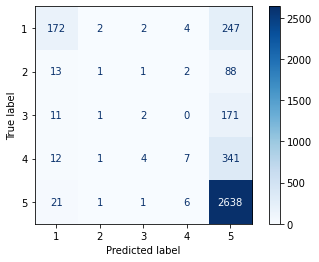

In [51]:
# Gráfico para GradientBoosting
disp = plot_confusion_matrix(best_model_gbc, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

### g. XGBoost Classifier

```python
pipe7 = Pipeline(steps=[
    ("tran", tran),
    ('modelo_7', modelo_xgb)])

parametros_xgb = {"modelo_7__learning_rate": [0.01, 0.1],
                  "modelo_7__n_estimators" : [100, 500],
                  "modelo_7__subsample": [0.1,0.5]}
```

In [56]:
%%time
search_xgb = GridSearchCV(pipe7, parametros_xgb, cv =2,n_jobs=-1).fit(X_train, y_train)
best_model_xgb = search_xgb.best_estimator_

pickle.dump(best_model_xgb, open("modelo_xgb_01.sav","wb"))

CPU times: user 9min 50s, sys: 874 ms, total: 9min 51s
Wall time: 1h 32min 28s


In [57]:
search_xgb.best_params_

{'modelo_7__learning_rate': 0.1,
 'modelo_7__n_estimators': 100,
 'modelo_7__subsample': 0.5}

In [58]:
# Carga del modelo con pickle
modelo_xgb_01 = pickle.load(open("modelo_xgb_01.sav","rb"))

#predicción
y_pred_xgb = modelo_xgb_01.predict(X_test)
y_pred_train_xgb = modelo_xgb_01.predict(X_train)

In [59]:
report(y_train,y_pred_train_xgb,y_test,y_pred_xgb)

Classification report - TRAIN SET
              precision    recall  f1-score   support

         1.0       0.80      0.53      0.64       627
         2.0       0.94      0.18      0.31       186
         3.0       0.86      0.14      0.24       263
         4.0       0.91      0.16      0.27       553
         5.0       0.79      0.99      0.88      3994

    accuracy                           0.79      5623
   macro avg       0.86      0.40      0.47      5623
weighted avg       0.81      0.79      0.74      5623


Classification report - TEST SET
              precision    recall  f1-score   support

         1.0       0.74      0.48      0.59       427
         2.0       0.12      0.01      0.02       105
         3.0       0.33      0.02      0.04       185
         4.0       0.37      0.05      0.09       365
         5.0       0.77      0.98      0.86      2667

    accuracy                           0.76      3749
   macro avg       0.47      0.31      0.32      3749
weighted 

Al igual que lo ocurrido con el modelo anterior, XGBoosting presenta un menor desempeño que el modelo de base para la grill de parámetros definida. Se indagará en un nuevo set para buscar un mejor desempeño.

#### Matriz de confusión

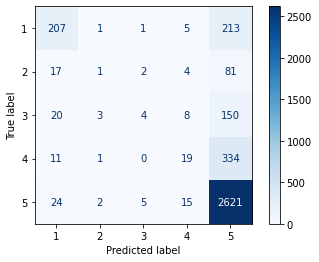

In [60]:
# Gráfico para GradientBoosting
disp = plot_confusion_matrix(best_model_xgb, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

<H1 align="center"> <div class="alert alert-block alert-info"><b></b>Acá empieza aplicación de balanceo de clases</div></H1>

### 9.7. Aplicación de SMOTE para balanceo de clases

In [88]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as pipe
smt = SMOTE(random_state = 123)

In [67]:
# Definición de mejor modelo
modelo_xgb_best = XGBClassifier(learning_rate = 0.1, n_estimators = 100, subsample=0.5, random_state = 123)

In [89]:
pipe_bm = pipe([("tran", tran),
              ('sampling', SMOTE()),
              ('modelo_xgb_best', modelo_xgb_best)])

pipe_bm.fit(X_train, y_train)
y_pred = pipe_bm.predict(X_test)

In [91]:
test_classification_report('XGBoost', y_test, y_pred)


TEST SET - Classification report - XGBOOST
              precision    recall  f1-score   support

         1.0       0.74      0.49      0.59       427
         2.0       0.00      0.00      0.00       105
         3.0       0.22      0.01      0.02       185
         4.0       0.21      0.01      0.02       365
         5.0       0.76      0.98      0.86      2667

    accuracy                           0.76      3749
   macro avg       0.39      0.30      0.30      3749
weighted avg       0.66      0.76      0.68      3749



In [ ]:
# Gráfico para GradientBoosting
disp = plot_confusion_matrix(best_model_xgb, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()